## **Tugas Proyek Analisis Setimen**
Nama : Nisrina Fatimah Parisya

ID Cohort : MC006D5X1393

Tema Tugas : Analisis Sentimen pada Aplikasi


In [ ]:
!pip install sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

In [ ]:
!pip install swifter

# Import Library

In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import csv
import string
from tqdm.notebook import tqdm
tqdm.pandas()
import time
import swifter
swifter.set_defaults(display_progressbar=True)
import requests
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier


In [ ]:
nltk.download('punkt_tab', force=True)
nltk.download('stopwords', force=True)
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Load Dataset

In [ ]:
df_webtoon_review = pd.read_csv('/content/webtun/review_webtoon.csv')

In [ ]:
df_webtoon_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              103500 non-null  object
 1   userName              103500 non-null  object
 2   userImage             103500 non-null  object
 3   content               103500 non-null  object
 4   score                 103500 non-null  int64 
 5   thumbsUpCount         103500 non-null  int64 
 6   reviewCreatedVersion  79968 non-null   object
 7   at                    103500 non-null  object
 8   replyContent          345 non-null     object
 9   repliedAt             345 non-null     object
 10  appVersion            79968 non-null   object
dtypes: int64(2), object(9)
memory usage: 8.7+ MB


In [ ]:
def clean_webtoon_data(df):
    # 1. Hapus baris yang tidak punya isi review
    df = df[df['content'].notna()].copy()

    # 2. Isi nilai kosong di kolom yang tidak krusial
    df['userImage'] = df['userImage'].fillna('default.jpg')
    df['reviewCreatedVersion'] = df['reviewCreatedVersion'].fillna('unknown')
    df['appVersion'] = df['appVersion'].fillna('unknown')
    df['replyContent'] = df['replyContent'].fillna('no reply')

    # 3. Isi nilai kosong di kolom tanggal dengan pd.NaT (null datetime)
    df['at'] = df['at'].fillna(pd.NaT)
    df['repliedAt'] = df['repliedAt'].fillna(pd.NaT)

    # 4. Isi angka kosong jika ada (optional, tergantung kebutuhan)
    if df['score'].isnull().any():
        df['score'] = df['score'].fillna(df['score'].median())
    if df['thumbsUpCount'].isnull().any():
        df['thumbsUpCount'] = df['thumbsUpCount'].fillna(0)

    return df

df_cleaned = clean_webtoon_data(df_webtoon_review)
print(df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103500 entries, 0 to 103499
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              103500 non-null  object
 1   userName              103500 non-null  object
 2   userImage             103500 non-null  object
 3   content               103500 non-null  object
 4   score                 103500 non-null  int64 
 5   thumbsUpCount         103500 non-null  int64 
 6   reviewCreatedVersion  103500 non-null  object
 7   at                    103500 non-null  object
 8   replyContent          103500 non-null  object
 9   repliedAt             345 non-null     object
 10  appVersion            103500 non-null  object
dtypes: int64(2), object(9)
memory usage: 8.7+ MB
None


# Preprocesing Text

In [ ]:
def cleaningText(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    text = text.replace('\n', ' ').strip()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'#[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'@[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    return text

def casefoldingText(text):
    text = text.lower()
    return text


def tokenizing(text):
    return word_tokenize(text)

def filterText(tokens):
    stop_words = set(stopwords.words('indonesian') + stopwords.words('english'))
    stop_words.update([
        'yea','yaa','di','wei','woy','deh','dong','tuh','gitu','aja',
        'kah','lah','gak','loh','duh','dih','ku','gaa','yaaa','ntar','lg'
    ])
    return [word for word in tokens if word not in stop_words]

def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    stemmed_text = stemmer.stem(' '.join(text))
    return stemmed_text.split()

def ubahKalimat(daftarkalimat):
    return ' '.join(daftarkalimat)

In [ ]:
slang = {
    "lol": "lucu",
    "abis": "habis",
    "bgt": "sangat",
    "btw": "ngomong-ngomong",
    "fix": "pasti",
    "delay": "lambat merespons",
    "ngaco": "kacau",
    "app" : "aplikasi",
    "crash": "aplikasi berhenti",
    "lemot": "lama",
    "instal":"mengunduh",
    "install":"mengunduh",
    "ngulang": "mengulang",
    "ribet": "rumit",
    "guys": "teman-teman",
    "kayak": "seperti",
    "apk": "aplikasi",
    "kepo": "ingin tahu",
    "error": "gagal",
    "bug": "masalah teknis",
    "glitch": "gangguan tampilan",
    "loading": "memuat",
    "buffering": "proses loading lama",
    "skip": "lewati",
    "spoiler": "bocoran cerita",
    "update": "pembaruan",
    "komen": "komentar",
    "rate": "penilaian",
    "fav": "favorit",
    "rekomend": "rekomendasi",
    "kocak": "lucu",
    "gemoy": "imut",
    "ship": "dukung pasangan",
    "plot": "alur cerita",
    "cliff": "cliffhanger",
    "teaser": "cuplikan",
    "spoiler": "bocoran",
    "scroll": "gulir",
    "zoom": "perbesar",
    "resolusi": "kualitas gambar",
    "darkmode": "mode gelap",
    "notif": "notifikasi",
    "subs": "berlangganan",
    "premium": "berbayar",
    "free": "gratis",
    "ads": "iklan",
    "lag": "lambat",
    "stuck": "macet",
    "kudu": "harus",
    "kuy": "ayo",
    "cmiiw": "koreksi jika saya salah",
    "gercep": "cepat tanggap",
    "hiks": "sedih",
    "wkwk": "tertawa",
    "mager": "malas gerak",
    "santuy": "santai",
    "panutan": "contoh baik",
    "nyesel": "menyesal",
    "bet": "nyaman",
    "jadul": "jaman dulu",
    "jleb": "kena hati",
    "salfok": "salah fokus",
    "sabi": "salah sendiri",
    "gaje": "gak jelas",
    "bucin": "budak cinta",
    "baper": "bawa perasaan",
    "ygy": "ya guys ya",
    "sist": "sister (kakak/adik)",
    "bro": "brother (teman)",
    "anjay": "wah (ekspresi)",
    "sokin": "sok penting",
    "gws": "semoga cepat sembuh",
    "receh": "lucu receh",
    "sotoy": "sok tahu",
    "typo": "salah ketik",
    "yha": "ya sudah",

}
def example_slangwords(text):
    words = text.split()
    katafix = []
    for kata in words:
        if kata.lower() in slang:
            katafix.append(slang[kata.lower()])
        else:
            katafix.append(kata)
    return ' '.join(katafix)

In [ ]:
#df baru biar lebih aman buat modeling data nanti
df_processed = df_cleaned.copy()

In [ ]:
df_processed['clean_text'] = df_processed['content'].progress_apply(cleaningText)
df_processed ['text_casefoldingText'] = df_processed['clean_text'].progress_apply(casefoldingText)
df_processed['slang_fixed'] = df_processed['text_casefoldingText'].progress_apply(example_slangwords)
df_processed['tokens'] = df_processed['slang_fixed'].progress_apply(tokenizing)
df_processed['text_stopword'] = df_processed['tokens'].progress_apply(filterText)
df_processed['final_text'] = df_processed['text_stopword'].progress_apply(ubahKalimat)
df_processed.head()


  0%|          | 0/103500 [00:00<?, ?it/s]

  0%|          | 0/103500 [00:00<?, ?it/s]

  0%|          | 0/103500 [00:00<?, ?it/s]

  0%|          | 0/103500 [00:00<?, ?it/s]

  0%|          | 0/103500 [00:00<?, ?it/s]

  0%|          | 0/103500 [00:00<?, ?it/s]

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,clean_text,text_casefoldingText,slang_fixed,tokens,filtered_tokens,text_stopword,final_text
0,beabc610-0bc7-4046-bc00-d83c3d86c2db,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,saya menggunakan aplikasi ini sudah lama. Vitu...,5,443,3.6.2,2025-03-29 11:32:43,no reply,NaT,3.6.2,saya menggunakan aplikasi ini sudah lama Vitur...,saya menggunakan aplikasi ini sudah lama vitur...,saya menggunakan aplikasi ini sudah lama vitur...,"[saya, menggunakan, aplikasi, ini, sudah, lama...","[aplikasi, vitur², yg, aplikasi, oke, gambarga...","[aplikasi, vitur², yg, aplikasi, oke, gambarga...",aplikasi vitur² yg aplikasi oke gambargambarny...
1,28955196-2cea-4fad-9977-f0dab4a7e42f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Tampilan berandanya(home) aneh.. kayak ga bera...,4,1015,3.6.0,2025-03-06 22:01:26,no reply,NaT,3.6.0,Tampilan berandanyahome aneh kayak ga berasa k...,tampilan berandanyahome aneh kayak ga berasa k...,tampilan berandanyahome aneh seperti ga berasa...,"[tampilan, berandanyahome, aneh, seperti, ga, ...","[tampilan, berandanyahome, aneh, ga, berasa, t...","[tampilan, berandanyahome, aneh, ga, berasa, t...",tampilan berandanyahome aneh ga berasa tampila...
2,944f6d86-18f6-4445-8661-2a3d5f192846,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Untuk aplikasinya memang bagus, dan banyak fit...",5,1981,3.6.0,2025-03-05 08:00:52,no reply,NaT,3.6.0,Untuk aplikasinya memang bagus dan banyak fitu...,untuk aplikasinya memang bagus dan banyak fitu...,untuk aplikasinya memang bagus dan banyak fitu...,"[untuk, aplikasinya, memang, bagus, dan, banya...","[aplikasinya, bagus, fitur, membantu, manhwa, ...","[aplikasinya, bagus, fitur, membantu, manhwa, ...",aplikasinya bagus fitur membantu manhwa dewasa...
3,46c1091b-6341-4678-bf78-2460b5395870,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,padahal tampilan awal 'home' udah bagus dan te...,3,78,3.6.0,2025-03-01 00:39:18,no reply,NaT,3.6.0,padahal tampilan awal home udah bagus dan terb...,padahal tampilan awal home udah bagus dan terb...,padahal tampilan awal home udah bagus dan terb...,"[padahal, tampilan, awal, home, udah, bagus, d...","[tampilan, home, udah, bagus, terbiasa, eh, di...","[tampilan, home, udah, bagus, terbiasa, eh, di...",tampilan home udah bagus terbiasa eh diubah ta...
4,5cda986f-1998-4d45-be45-f6dc9fd80760,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"sebenarnya bagus, update-annya juga lucu (ada ...",4,1540,3.5.3,2025-02-12 12:15:56,no reply,NaT,3.5.3,sebenarnya bagus updateannya juga lucu ada sti...,sebenarnya bagus updateannya juga lucu ada sti...,sebenarnya bagus updateannya juga lucu ada sti...,"[sebenarnya, bagus, updateannya, juga, lucu, a...","[bagus, updateannya, lucu, stikernya, kurangny...","[bagus, updateannya, lucu, stikernya, kurangny...",bagus updateannya lucu stikernya kurangnya kom...


# Labeling Data

In [ ]:
def load_lexicon(url):
    lexicon = {}
    response = requests.get(url)

    if response.status_code == 200:
        reader = csv.reader(StringIO(response.text), delimiter=',')
        for row in reader:
            lexicon[row[0]] = int(row[1])
    else:
        print(f"Gagal mengambil data dari: {url}")

    return lexicon

# URL untuk kamus kata positif dan negatif
url_positive = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv'
url_negative = 'https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv'

# Panggil fungsi untuk ambil datanya
lexicon_positive = load_lexicon(url_positive)
lexicon_negative = load_lexicon(url_negative)

In [ ]:
def hitung_sentimen(kata_token):
    skor = 0
    positif_ditemukan = []
    negatif_ditemukan = []

    for kata in kata_token:
        if kata in lexicon_positive:
            skor += lexicon_positive[kata]
            positif_ditemukan.append(kata)
        elif kata in lexicon_negative:
            skor += lexicon_negative[kata]
            negatif_ditemukan.append(kata)

    if skor > 0:
        polaritas = 'positif'
    elif skor < 0:
        polaritas = 'negatif'
    else:
        polaritas = 'netral'

    return skor, polaritas

In [ ]:
results = df_processed['filtered_tokens'].apply(hitung_sentimen)

# Pisahkan hasil tuple jadi dua kolom
results = list(zip(*results))
df_processed['skor_polaritas'] = results[0]
df_processed['polaritas'] = results[1]

# Cek distribusi polaritas
print(df_processed['polaritas'].value_counts())

polaritas
positif    67794
netral     21430
negatif    14276
Name: count, dtype: int64


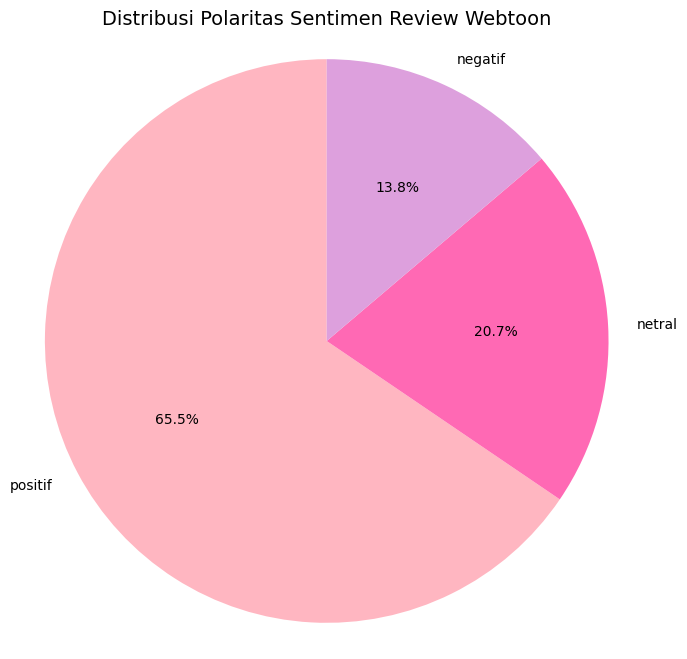

In [ ]:
polarity_counts = df_processed['polaritas'].value_counts()

# visualisasi
colors =['#FFB6C1', '#FF69B4', '#DDA0DD']
plt.figure(figsize=(8, 8))
plt.pie(polarity_counts, labels=polarity_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Distribusi Polaritas Sentimen Review Webtoon', fontsize=14)
plt.axis('equal')

plt.show()


# Data Spiltting

In [ ]:
# Split data
X = df_processed['final_text']
y = df_processed['polaritas']

# melakukan proses TF-IDF
vectorizer = TfidfVectorizer(max_features=10000)
X_tfidf = vectorizer.fit_transform(X)

#Modeling Data

#### Random Forest (80/20)

In [ ]:
# Split data (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Check bentuk training dan testing dataset
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Memory usage is now optimized by using sparse matrices")

Training set shape: (82800, 10000)
Testing set shape: (20700, 10000)
Memory usage is now optimized by using sparse matrices


In [ ]:
# inisialisasi
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42) # You can adjust n_estimators

# latih data
rf_classifier.fit(X_train, y_train)

# buat prediksi
y_pred_rf = rf_classifier.predict(X_test)

# evaluasi
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.9085990338164252
              precision    recall  f1-score   support

     negatif       0.90      0.59      0.71      2861
      netral       0.94      0.88      0.91      4230
     positif       0.90      0.98      0.94     13609

    accuracy                           0.91     20700
   macro avg       0.92      0.82      0.85     20700
weighted avg       0.91      0.91      0.90     20700



#### Logistic Regresion (70/30)

In [ ]:
# Split data (70/30)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

# Check shapes of training and testing datasets
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Memory usage is now optimized by using sparse matrices")


Training set shape: (72450, 10000)
Testing set shape: (31050, 10000)
Memory usage is now optimized by using sparse matrices


In [ ]:
# Inisialisasi model Logistic Regression
logreg_classifier = LogisticRegression(max_iter=1000, random_state=42) # Menambah max_iter

# training
logreg_classifier.fit(X_train, y_train)

# Buat prediksi
y_pred_logreg = logreg_classifier.predict(X_test)

# Evaluasi
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
print(f"Logistic Regression Accuracy: {accuracy_logreg}")
print(classification_report(y_test, y_pred_logreg))


Logistic Regression Accuracy: 0.9413848631239936
              precision    recall  f1-score   support

     negatif       0.91      0.82      0.86      4230
      netral       0.89      0.90      0.89      6388
     positif       0.96      0.98      0.97     20432

    accuracy                           0.94     31050
   macro avg       0.92      0.90      0.91     31050
weighted avg       0.94      0.94      0.94     31050



#### SGDClassifier (70/30)

In [ ]:
# Split data (70/30)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

# Check shapes of training and testing datasets
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Memory usage is now optimized by using sparse matrices")

Training set shape: (72450, 10000)
Testing set shape: (31050, 10000)
Memory usage is now optimized by using sparse matrices


In [ ]:
# Inisialisasi model SGDClassifier
sgd_classifier = SGDClassifier(random_state=42)

# Latih model
sgd_classifier.fit(X_train, y_train)

# Buat prediksi
y_pred_sgd = sgd_classifier.predict(X_test)

# Evaluasi model
accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
print(f"SGD Classifier Accuracy: {accuracy_sgd}")
print(classification_report(y_test, y_pred_sgd))


SGD Classifier Accuracy: 0.9234460547504025
              precision    recall  f1-score   support

     negatif       0.91      0.74      0.82      4230
      netral       0.87      0.89      0.88      6388
     positif       0.94      0.97      0.96     20432

    accuracy                           0.92     31050
   macro avg       0.91      0.87      0.88     31050
weighted avg       0.92      0.92      0.92     31050



# Proses Inference

In [ ]:
def predict_sentiment(text, model=logreg_classifier, vectorizer=vectorizer):
    # Preprocess the input text
    cleaned_text = cleaningText(text)
    casefolded_text = casefoldingText(cleaned_text)
    slang_fixed_text = example_slangwords(casefolded_text)
    tokens = tokenizing(slang_fixed_text)
    filtered_tokens = filterText(tokens)
    final_text = ubahKalimat(filtered_tokens)

    # Vectorize the text using the same vectorizer used during training
    text_tfidf = vectorizer.transform([final_text])

    # Predict the sentiment using the chosen model
    prediction = model.predict(text_tfidf)[0]

    return prediction

# Example usage
user_input = input("Enter a review: ")
predicted_sentiment = predict_sentiment(user_input)
print(f"Predicted sentiment: {predicted_sentiment}")


Enter a review: aplikaisnya menarik! saya terhibur dengan membaca seri webcomic terbaru dari artist lokal
Predicted sentiment: positif


# Requirenment

In [ ]:
!pip install pipreqs

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.3 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=9a5b3e5e4e1958ff3f2bc454671274635c5baeb418835bdad587e43687f45344
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.12.3 which is incompatible.


In [ ]:
!pip freeze | grep 'pandas\|numpy\|matplotlib\|seaborn\|nltk\|tqdm\|swifter\|requests\|wordcloud' > requirements.txt
!cat requirements.txt

geopandas==1.0.1
matplotlib==3.10.0
matplotlib-inline==0.1.7
matplotlib-venn==1.1.2
nltk==3.9.1
numpy==2.0.2
pandas==2.2.2
pandas-datareader==0.10.0
pandas-gbq==0.28.0
pandas-stubs==2.2.2.240909
requests==2.32.3
requests-oauthlib==2.0.0
requests-toolbelt==1.0.0
seaborn==0.13.2
sklearn-pandas==2.2.0
swifter==1.4.0
tqdm==4.67.1
wordcloud==1.9.4
